In [ ]:
# Install Library
!pip install pytorch-fid

In [4]:
# Declare imports and initialize some variables like hyperparameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from pytorch_fid import fid_score

file_path = os.getcwd() + "/generator_epochs_"

# Size of training batches
batchSize = 64
# Number of channels in the image
nChannels = 3
# Size of generational vector
vectorSize = 100
# Feature space of Generator
nGenFeats = 32
# Feature space of Discriminator
nDiscFeats = 32
# Number of training epochs
nEpochs = 100
# When to take model snapshots
nSnapshots = 10
# Learning rate for optimizers
lr = 0.0002

# The device the model runs on (gpu vs cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the loss function (Binary Cross Entropy)
criterion = nn.BCELoss()

# Define real and fake label values
REAL_LABEL = 1.
FAKE_LABEL = 0.

Files already downloaded and verified
Files already downloaded and verified


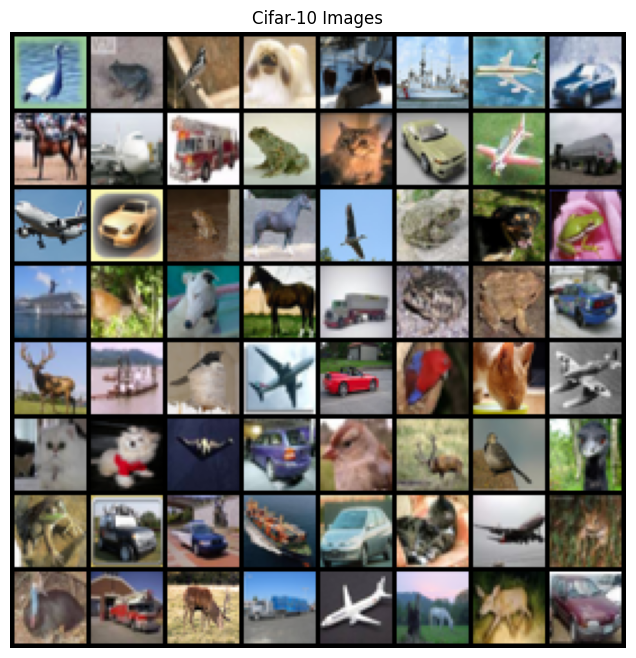

In [2]:
# CIFAR10 preprocessing

# Define data transformations and normalization
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
real_dataset = datasets.CIFAR10(root='./data', train=True,
download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,
download=True, transform=transform)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=batchSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Plot some images
real_batch = next(iter(real_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Cifar-10 Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [3]:
# Generator neural net here maybe
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is vector, going into a convolution
            nn.ConvTranspose2d( vectorSize, nGenFeats * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nGenFeats * 4),
            nn.ReLU(True),
            # state size. ``(nGenFeats*8) x 4 x 4``
            nn.ConvTranspose2d(nGenFeats * 4, nGenFeats * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nGenFeats * 2),
            nn.ReLU(True),
            # state size. ``(nGenFeats*4) x 8 x 8``
            nn.ConvTranspose2d( nGenFeats * 2, nGenFeats, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nGenFeats),
            nn.ReLU(True),
            # state size. ``(nGenFeats*2) x 16 x 16``
            nn.ConvTranspose2d( nGenFeats, nChannels, 4, 2, 1, bias=False),
            nn.Tanh()            
            # state size. ``3 x 32 x 32``
        )

    def forward(self, input):
        return self.main(input)

genModel = Generator().to(device)
optimizerG = optim.Adam(genModel.parameters(), lr=lr, betas=(0.5, 0.999))

In [4]:
# Discriminator neural net here
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``3 x 32 x 32``
            nn.Conv2d(nChannels, nDiscFeats, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(nDiscFeats) x 16 x 16``
            nn.Conv2d(nDiscFeats, nDiscFeats * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nDiscFeats * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(nDiscFeats*2) x 8 x 8``
            nn.Conv2d(nDiscFeats * 2, nDiscFeats * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nDiscFeats * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(nDiscFeats*4) x 4 x 4``
            nn.Conv2d(nDiscFeats * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

discModel = Discriminator().to(device)
optimizerD = optim.Adam(discModel.parameters(), lr=lr, betas=(0.5, 0.999))

Starting Training Loop...
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100


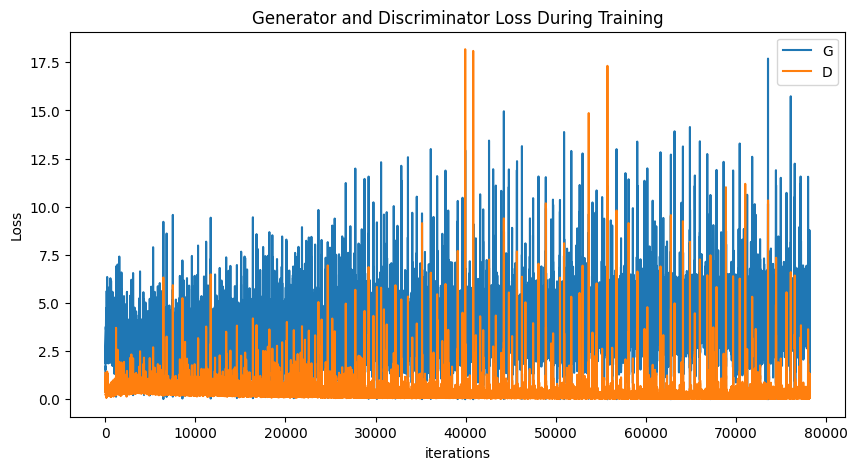

In [22]:
# We'll train the neural nets here and make sure to save the trained neural nets to be called later

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Training Loop
print("Starting Training Loop...")
# For each epoch
for epoch in range(nEpochs):
    if (epoch + 1) % nSnapshots == 0:
        print (f'Epoch: {epoch + 1}')
        #torch.save(genModel, file_path + str(epoch + 1) + ".pth")
        
    # For each batch in the dataloader
    for i, data in enumerate(real_loader, 0):
        ## Train with all-real batch
        discModel.zero_grad()
        # Format batch
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        label = torch.full((batch_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discModel(real_data).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, vectorSize, 1, 1, device=device)
        # Format batch
        fake_data = genModel(noise)
        label.fill_(FAKE_LABEL)
        # Forward pass real batch through D
        output = discModel(fake_data.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ## Update generator 
        genModel.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discModel(fake_data).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Save model
torch.save(genModel, file_path + str(nEpochs) + ".pth")

with torch.no_grad():
    noise = torch.randn(batchSize, vectorSize, 1, 1, device=device)
    fake = genModel(noise)
    
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(utils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))

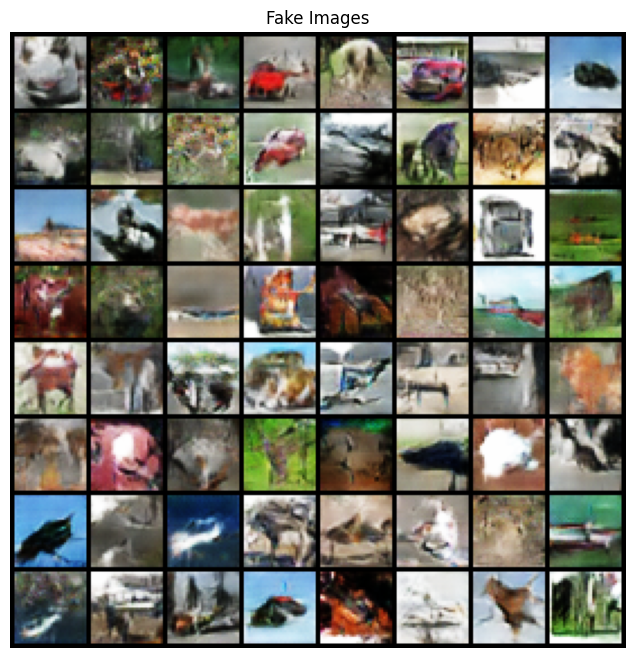

In [7]:
# Load model and display generated images
epoch_model = 100
genModel = torch.load(file_path + str(epoch_model) + ".pth")

with torch.no_grad():
    noise = torch.randn(batchSize, vectorSize, 1, 1, device=device)
    fake = genModel(noise)
    
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(utils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# Save 10000 GAN generated images
with torch.no_grad():
    for j in range(100):
        noise = torch.randn(100, vectorSize, 1, 1, device=device)
        fake = genModel(noise)
        for i, img in enumerate(fake):
            # print(img)
            save_image(img, "./data/GAN_generated_images/image_" + str(j) + "_" + str(i) + ".png")

In [ ]:
# Dumb way to do this !!!
# Save cifar-10 images
for j, data in enumerate(test_loader, 0):
    for i, img in enumerate(data[0], 0):
        # print(img)
        save_image(img, "./data/cifar-10_images/image_" + str(j) + "_" + str(i) + ".png")

In [113]:
# Calculate FID score
fid = fid_score.calculate_fid_given_paths(["./data/cifar-10_images/","./data/GAN_generated_images/"], batch_size=64 , device=device, dims=2048)
fid

25.91259817597097

In [ ]:
# install libraries for DDPM
!pip install accelerate
!pip install git+https://github.com/huggingface/diffusers

100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


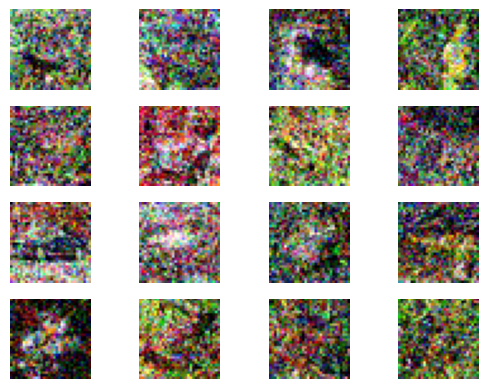

In [20]:
# Load DDPM model
from diffusers import DDPMPipeline

model_id = "google/ddpm-cifar10-32"

# load model and scheduler
ddpm = DDPMPipeline.from_pretrained(model_id)  
images = ddpm(batch_size = 16, num_inference_steps = 10).images

i = 0 
fig, axes = plt.subplots(4, 4)
for row in range(4):
    for column in range(4):
        ax = axes[row, column]
        ax.axis('off')
        ax.imshow(images[i])
        i += 1
        
plt.show()

In [ ]:
# Save 10000 DDPM generated images
# Takes like a minute each batch
for j in range(100):
    # run pipeline in inference (sample random noise and denoise)
    images = ddpm(batch_size = 100, num_inference_steps = 10).images
    for i, image in enumerate(images):
      image.save("./data/DDPM_generated_images/image_" + str(j) + "_" + str(i) + ".png")

In [ ]:
ddpm_dataset = datasets.CIFAR10(root='./data', train=False,
download=True, transform=transform)
ddpm_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Plot some images
real_batch = next(iter(real_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Cifar-10 Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [18]:
# Calculate FID score
fid = fid_score.calculate_fid_given_paths(["./data/cifar-10_images/","./data/DDPM_generated_images/"], batch_size=64 , device=device, dims=2048)
fid

299.63159025375796